## Importing the relevant libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from copy import deepcopy

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


sns.set_theme()

## Loading the raw data

In [2]:
df_main = pd.read_csv('cars_dataset.csv')
df = df_main.copy()
df.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


In [3]:
df.shape

(4345, 9)

## Preprocessing

### Exploring the Descriptive Statistics of the Variables

In [4]:
df.describe(include='all').round(2)

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4345,4173.00,4345,4345.00,4195.00,4345,4345,4345.00,4345
unique,7,NaN,6,NaN,NaN,4,2,NaN,312
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,936,NaN,1649,NaN,NaN,2019,3947,NaN,199
mean,NaN,19418.75,NaN,161.24,2.79,NaN,NaN,2006.55,NaN
std,NaN,25584.24,NaN,105.71,5.07,NaN,NaN,6.72,NaN
min,NaN,600.00,NaN,0.00,0.60,NaN,NaN,1969.00,NaN
25%,NaN,6999.00,NaN,86.00,1.80,NaN,NaN,2003.00,NaN
50%,NaN,11500.00,NaN,155.00,2.20,NaN,NaN,2008.00,NaN
75%,NaN,21700.00,NaN,230.00,3.00,NaN,NaN,2012.00,NaN


### Determining the Variables of Interest

In [5]:
df = df.drop(['Model','Registration'], axis=1)

### Dealing with Missing Values

In [6]:
df.isnull().sum()

Brand            0
Price          172
Body             0
Mileage          0
EngineV        150
Engine Type      0
Year             0
dtype: int64

In [7]:
df.dropna(axis=0, ignore_index=True, inplace=True)

In [8]:
df.isnull().sum()

Brand          0
Price          0
Body           0
Mileage        0
EngineV        0
Engine Type    0
Year           0
dtype: int64

In [9]:
df.shape

(4025, 7)

### Exploring the Distribution and Dealing with Outliers

#### Price

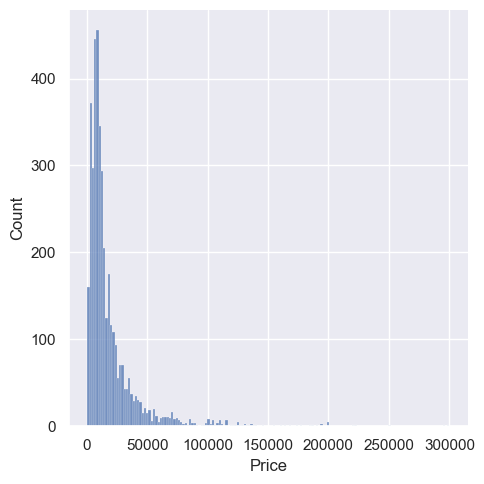

In [10]:
sns.displot(df['Price'])
plt.show()

In [11]:
q = df['Price'].quantile(0.99)
df = df[df['Price']<q]

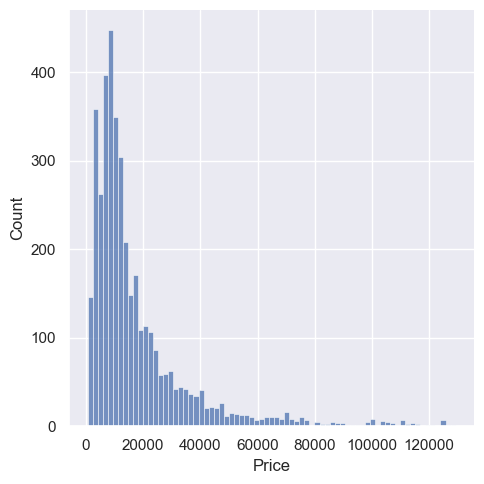

In [12]:
sns.displot(df['Price'])
plt.show()

#### Mileage

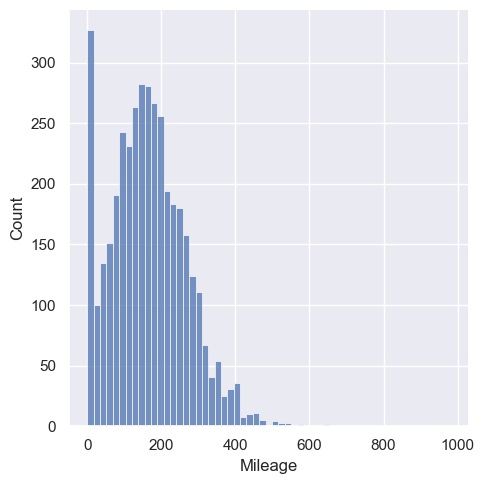

In [13]:
sns.displot(df['Mileage'])
plt.show()

In [14]:
q = df['Mileage'].quantile(0.99)
df = df[df['Mileage']<q]

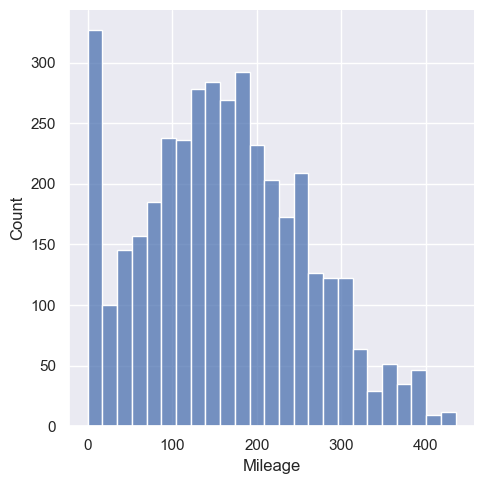

In [15]:
sns.displot(df['Mileage'])
plt.show()

#### EngineV

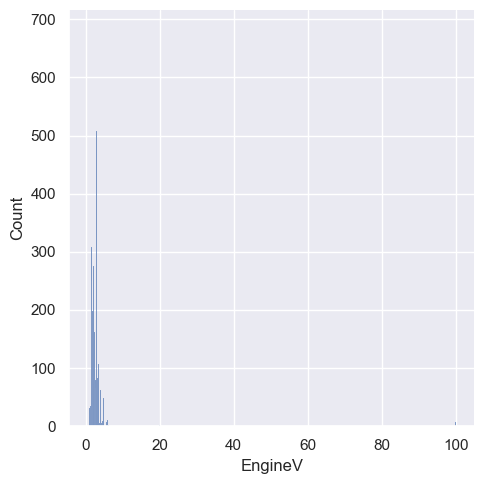

In [16]:
sns.displot(df['EngineV'])
plt.show()

In [17]:
df = df[df['EngineV']<6.5]

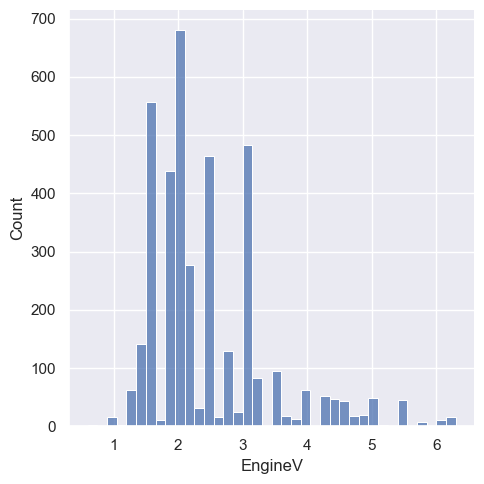

In [18]:
sns.displot(df['EngineV'])
plt.show()

#### Year

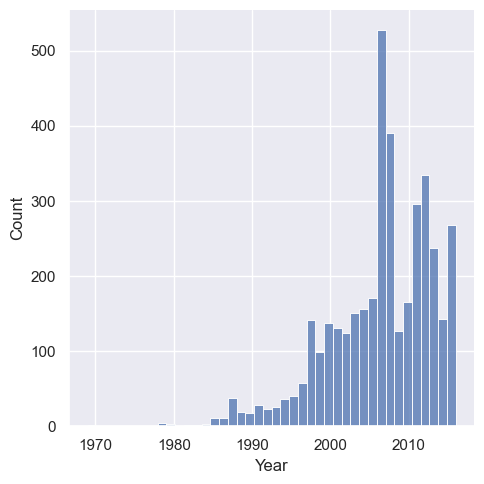

In [19]:
sns.displot(df['Year'])
plt.show()

In [20]:
q = df['Year'].quantile(0.01)
df = df[df['Year']>q]

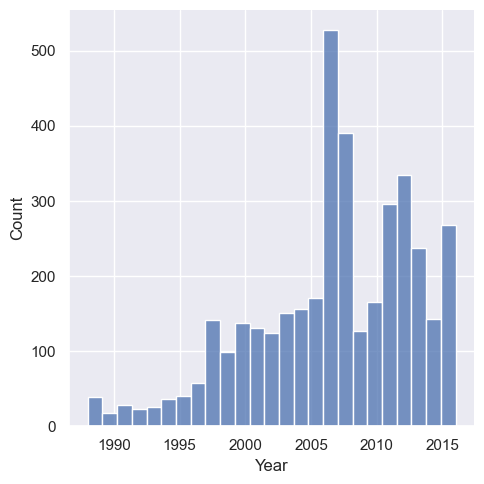

In [21]:
sns.displot(df['Year'])
plt.show()

In [22]:
df.reset_index(drop=True, inplace=True)

## Categorizing Variables

In [23]:
df.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Year
0,BMW,4200.0,sedan,277,2.0,Petrol,1991
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,1999
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,2003
3,Audi,23000.0,crossover,240,4.2,Petrol,2007
4,Toyota,18300.0,crossover,120,2.0,Petrol,2011


In [24]:
df.nunique()

Brand            7
Price          849
Body             6
Mileage        377
EngineV         55
Engine Type      4
Year            29
dtype: int64

In [25]:
# Initialize BinaryEncoder
onehot_encoder = ce.OneHotEncoder(use_cat_names=True)

# Fit and transform the data
df_encoded = onehot_encoder.fit_transform(df)

In [26]:
df_encoded.head()

,Brand_BMW,Brand_Mercedes-Benz,Brand_Audi,Brand_Toyota,Brand_Renault,Brand_Volkswagen,Brand_Mitsubishi,Price,Body_sedan,Body_van,...,Body_vagon,Body_other,Body_hatch,Mileage,EngineV,Engine Type_Petrol,Engine Type_Diesel,Engine Type_Gas,Engine Type_Other,Year
0,1,0,0,0,0,0,0,4200.0,1,0,...,0,0,0,277,2.0,1,0,0,0,1991
1,0,1,0,0,0,0,0,7900.0,0,1,...,0,0,0,427,2.9,0,1,0,0,1999
2,0,1,0,0,0,0,0,13300.0,1,0,...,0,0,0,358,5.0,0,0,1,0,2003
3,0,0,1,0,0,0,0,23000.0,0,0,...,0,0,0,240,4.2,1,0,0,0,2007
4,0,0,0,1,0,0,0,18300.0,0,0,...,0,0,0,120,2.0,1,0,0,0,2011


In [27]:
df_encoded.columns

Index(['Brand_BMW', 'Brand_Mercedes-Benz', 'Brand_Audi', 'Brand_Toyota',
       'Brand_Renault', 'Brand_Volkswagen', 'Brand_Mitsubishi', 'Price',
       'Body_sedan', 'Body_van', 'Body_crossover', 'Body_vagon', 'Body_other',
       'Body_hatch', 'Mileage', 'EngineV', 'Engine Type_Petrol',
       'Engine Type_Diesel', 'Engine Type_Gas', 'Engine Type_Other', 'Year'],
      dtype='object')

In [28]:
reference_level = ["Brand_BMW", "Body_sedan", "Engine Type_Petrol"]

In [29]:
df_encoded.drop(columns=reference_level, axis=1, inplace=True)

In [30]:
df_encoded.dtypes

Brand_Mercedes-Benz      int64
Brand_Audi               int64
Brand_Toyota             int64
Brand_Renault            int64
Brand_Volkswagen         int64
Brand_Mitsubishi         int64
Price                  float64
Body_van                 int64
Body_crossover           int64
Body_vagon               int64
Body_other               int64
Body_hatch               int64
Mileage                  int64
EngineV                float64
Engine Type_Diesel       int64
Engine Type_Gas          int64
Engine Type_Other        int64
Year                     int64
dtype: object

In [31]:
df_encoded.nunique()

Brand_Mercedes-Benz      2
Brand_Audi               2
Brand_Toyota             2
Brand_Renault            2
Brand_Volkswagen         2
Brand_Mitsubishi         2
Price                  849
Body_van                 2
Body_crossover           2
Body_vagon               2
Body_other               2
Body_hatch               2
Mileage                377
EngineV                 55
Engine Type_Diesel       2
Engine Type_Gas          2
Engine Type_Other        2
Year                    29
dtype: int64

## Checking the OLS assumptions

In [32]:
y = df_encoded["Price"]
X = df_encoded.drop("Price", axis=1)

### Linearity

In [33]:
# Identify boolean-like columns (columns with only 0 and 1)
X_boolean = [col for col in X.columns if set(X[col].unique()).issubset({0, 1})]

# Exclude boolean-like columns and select only continuous columns
X_nonboolean = X.drop(columns=X_boolean, axis=0)

# Display the new DataFrame
print(X_nonboolean)

      Mileage  EngineV  Year
0         277      2.0  1991
1         427      2.9  1999
2         358      5.0  2003
3         240      4.2  2007
4         120      2.0  2011
...       ...      ...   ...
3862      163      2.5  2008
3863       35      1.6  2014
3864        9      3.0  2014
3865        1      3.5  1999
3866      124      2.0  2013

[3867 rows x 3 columns]


In [34]:
def regression_plot(x, y):

    b1_slope, b0_intercept = np.polyfit(x, y, 1)
    y_pred = b0_intercept + x * b1_slope

    plt.figure(figsize=(6,3))
    plt.title(x.name + " and " + y.name)
    plt.scatter(x, y)
    plt.plot(x, y_pred, color='red', label='Regression Line')
    plt.show()

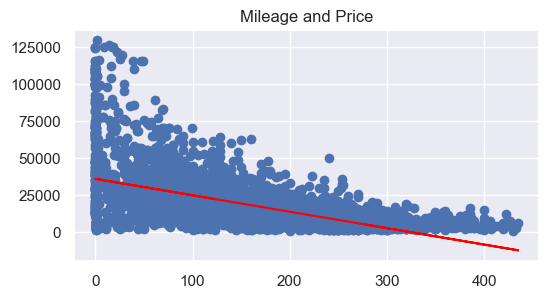

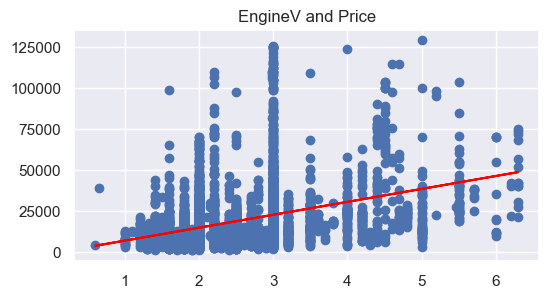

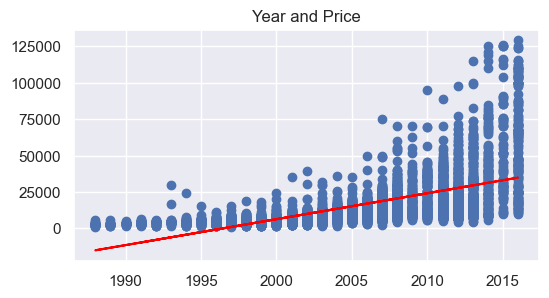

In [35]:
for col in X_nonboolean.columns:
    regression_plot(X[col], y)

In [36]:
price_log = pd.Series(np.log(y), name="Price_log")

In [37]:
price_log.head()

0     8.342840
1     8.974618
2     9.495519
3    10.043249
4     9.814656
Name: Price_log, dtype: float64

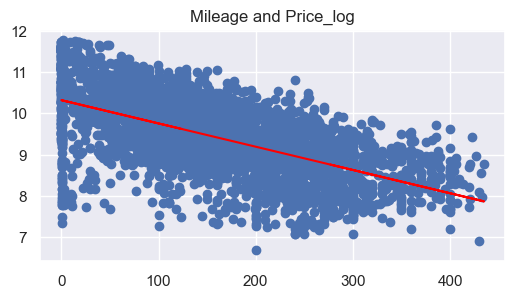

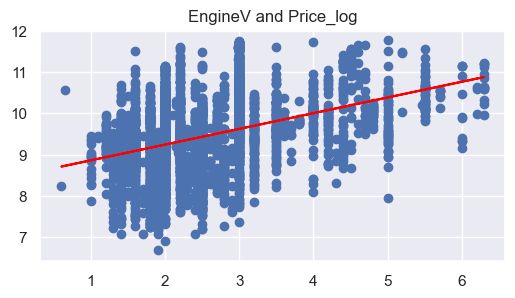

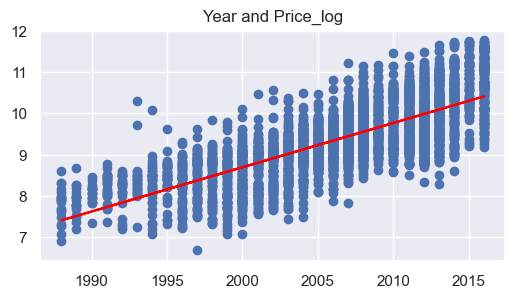

In [38]:
for col in X_nonboolean.columns:
    regression_plot(X[col], price_log)

In [39]:
y = price_log

In [40]:
del price_log

### No Endogeneity / Exogeneity

In [41]:
x = sm.add_constant(X)
# Fit the OLS model
model = sm.OLS(y, x).fit()
residuals = model.resid

X["residuals"] = residuals

In [42]:
resid_corr = X.corr().loc[["residuals"],:"Year"] 
resid_corr

,Brand_Mercedes-Benz,Brand_Audi,Brand_Toyota,Brand_Renault,Brand_Volkswagen,Brand_Mitsubishi,Body_van,Body_crossover,Body_vagon,Body_other,Body_hatch,Mileage,EngineV,Engine Type_Diesel,Engine Type_Gas,Engine Type_Other,Year
residuals,6.237393e-15,-6.712967e-15,1.415949e-14,-1.066983e-14,1.179137e-14,1.261144e-14,-5.619948e-15,3.583335e-14,-5.391832e-15,-7.072971e-15,1.166189e-14,-8.109490e-14,8.047486e-15,-1.286014e-14,7.535700e-15,3.811308e-15,7.828263e-14


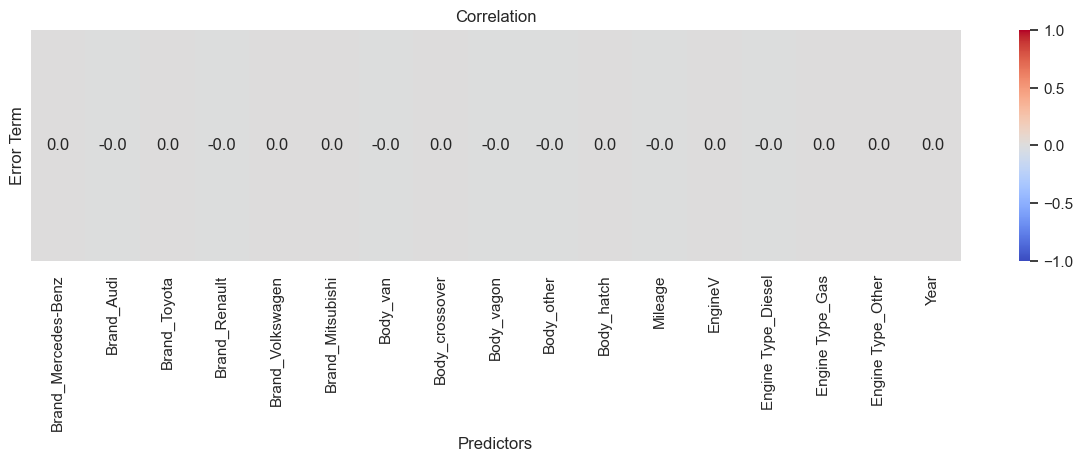

In [43]:
# Heatmap of Numeric Values Only
plt.figure(figsize=(15,3))
sns.heatmap(resid_corr, 
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            annot_kws={"rotation": 0},
            fmt=".1f"
)

plt.title('Correlation')
plt.ylabel('Error Term')
plt.yticks([])
plt.xlabel('Predictors')
plt.xticks(rotation=90)
plt.show()

In [44]:
X.drop("residuals", axis=1, inplace=True)

### Homoscedasticity / Constant Error Variance / No Heteroscedasticity

In [45]:
# Perform Breusch-Pagan test
bp_test = het_breuschpagan(residuals, model.model.exog) 

# Get the p-value
p_value = bp_test[1] 

# Print the results
print(f"Breusch-Pagan Test p-value for the Model: {p_value}")

# Interpret the results
if p_value < 0.05:
    print("Reject the null hypothesis of homoscedasticity.")
    print("There is evidence of heteroscedasticity.")
    print(f"The model is significant.\n")
else:
    print("Fail to reject the null hypothesis of homoscedasticity.")
    print("There is no evidence of heteroscedasticity.")
    print(f"The model is insignificant.\n")

Breusch-Pagan Test p-value for the Model: 9.724553190324416e-60
Reject the null hypothesis of homoscedasticity.
There is evidence of heteroscedasticity.
The model is significant.



### No Autocorrelation / Independant Error Terms / No Serial Correlation

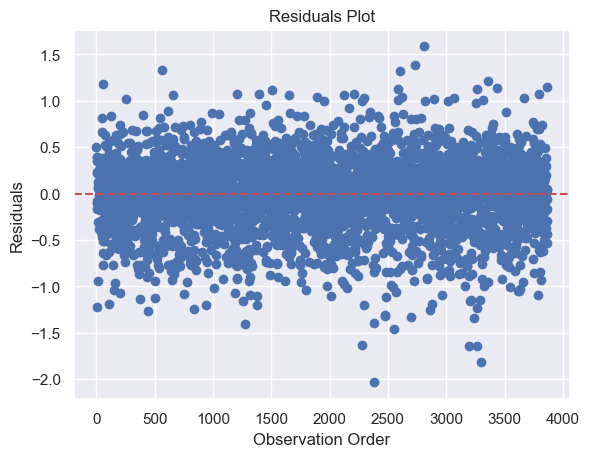

In [46]:
plt.scatter(residuals.index, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residuals Plot")
plt.xlabel("Observation Order")
plt.ylabel("Residuals")
plt.show()

In [47]:
# Range from 0 to 4, closer to 2 means no auto-correlation
dw_statistic = durbin_watson(residuals)
print(f"Durbin-Watson Statistic: {dw_statistic}")

Durbin-Watson Statistic: 2.0128097652022285


### No Multicollinearity

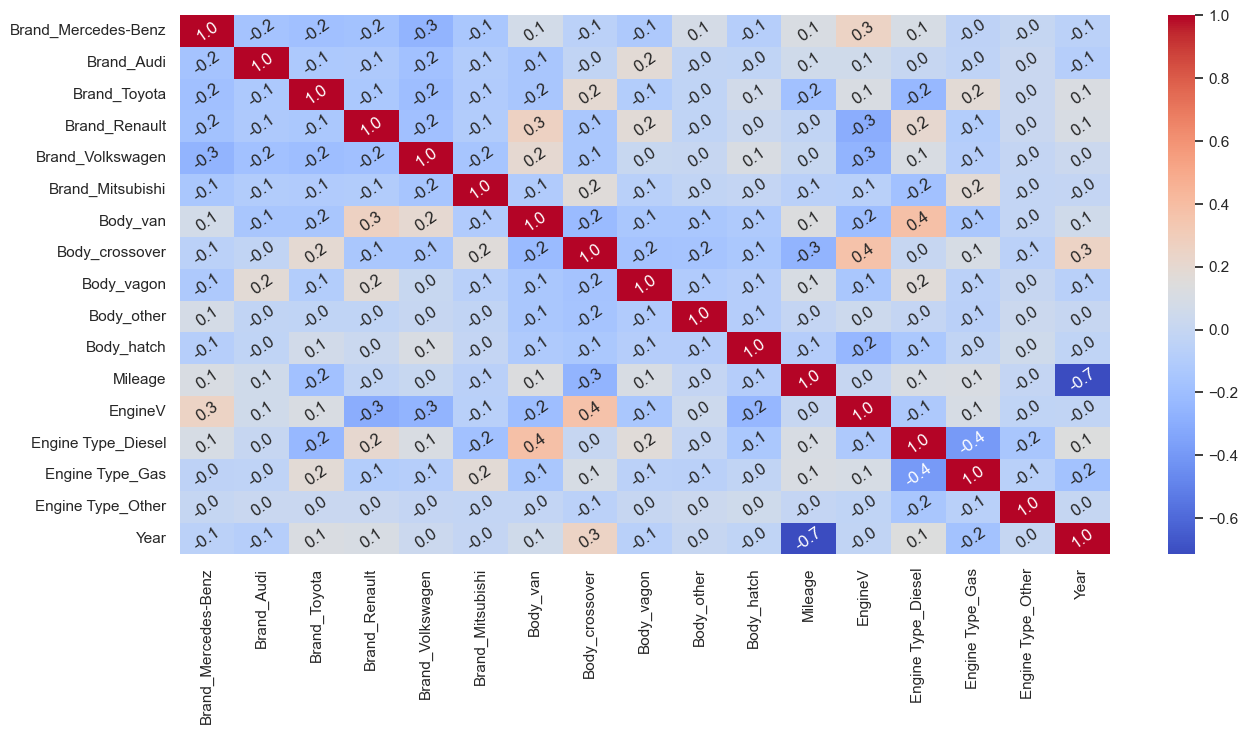

In [48]:
corr_matrix = X.corr()

plt.figure(figsize=(15,7))
sns.heatmap(corr_matrix, 
            annot=True,
            annot_kws={"rotation": 35},
            cmap='coolwarm', 
            fmt=".1f")
plt.xticks(rotation=90)
plt.show()

In [49]:
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

               Variable        VIF
0   Brand_Mercedes-Benz   2.352298
1            Brand_Audi   1.711194
2          Brand_Toyota   1.970450
3         Brand_Renault   2.210652
4      Brand_Volkswagen   2.825518
5      Brand_Mitsubishi   1.650549
6              Body_van   2.037706
7        Body_crossover   2.018121
8            Body_vagon   1.481393
9            Body_other   1.296800
10           Body_hatch   1.289098
11              Mileage   4.583264
12              EngineV  12.060969
13   Engine Type_Diesel   3.173997
14      Engine Type_Gas   1.545559
15    Engine Type_Other   1.082325
16                 Year  23.708187


In [50]:
drop_col = ["Year", "EngineV"]

X_multi = deepcopy(X)
X_multi.drop(columns=drop_col, axis=1, inplace=True)

vif_data = pd.DataFrame()
vif_data["Variable"] = X_multi.columns
vif_data["VIF"] = [variance_inflation_factor(X_multi.values, i) for i in range(X_multi.shape[1])]
print(vif_data)

               Variable       VIF
0   Brand_Mercedes-Benz  1.756192
1            Brand_Audi  1.386247
2          Brand_Toyota  1.428622
3         Brand_Renault  1.677898
4      Brand_Volkswagen  1.927412
5      Brand_Mitsubishi  1.299094
6              Body_van  2.034446
7        Body_crossover  1.611543
8            Body_vagon  1.474658
9            Body_other  1.258199
10           Body_hatch  1.216590
11              Mileage  3.132262
12   Engine Type_Diesel  3.020972
13      Engine Type_Gas  1.537098
14    Engine Type_Other  1.073887


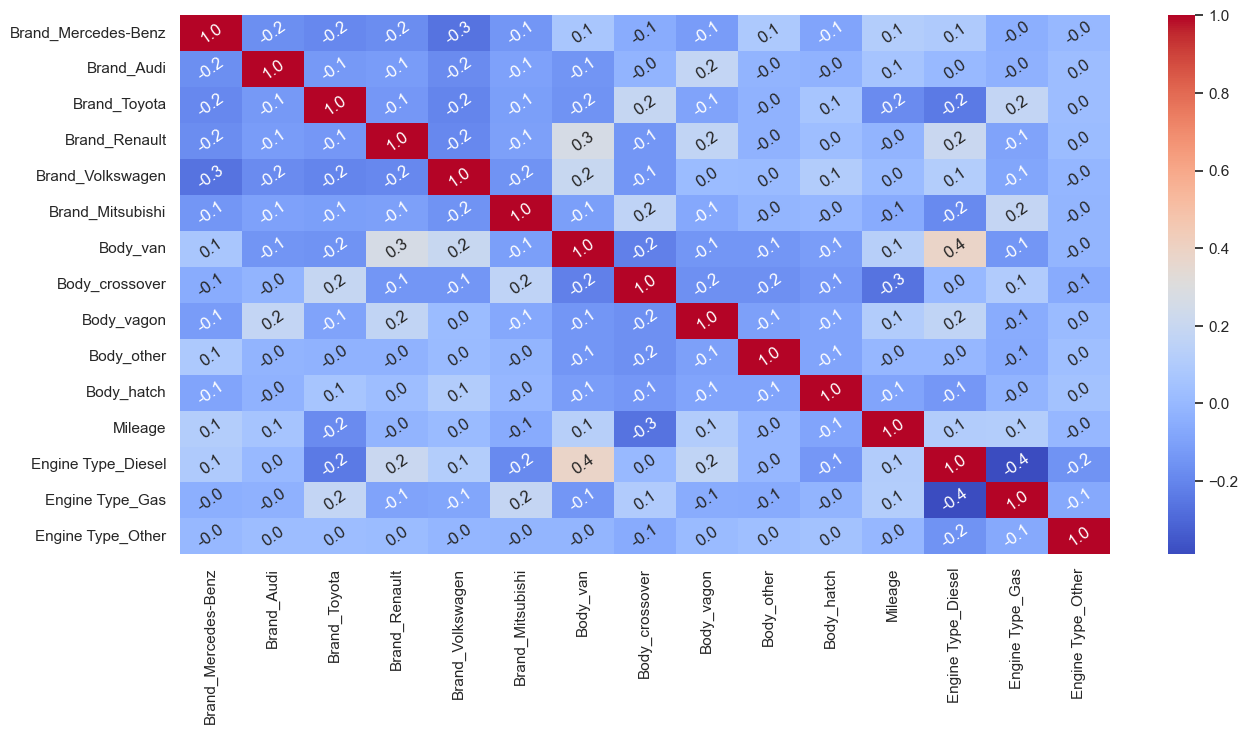

In [51]:
corr_matrix = X_multi.corr()

plt.figure(figsize=(15,7))
sns.heatmap(corr_matrix, 
            annot=True,
            annot_kws={"rotation": 35},
            cmap='coolwarm', 
            fmt=".1f")
plt.xticks(rotation=90)
plt.show()

## Linear regression model

### Features and Target

In [58]:
X = deepcopy(X_multi)
X.head()

,Brand_Mercedes-Benz,Brand_Audi,Brand_Toyota,Brand_Renault,Brand_Volkswagen,Brand_Mitsubishi,Body_van,Body_crossover,Body_vagon,Body_other,Body_hatch,Mileage,Engine Type_Diesel,Engine Type_Gas,Engine Type_Other
0,0,0,0,0,0,0,0,0,0,0,0,277,0,0,0
1,1,0,0,0,0,0,1,0,0,0,0,427,1,0,0
2,1,0,0,0,0,0,0,0,0,0,0,358,0,1,0
3,0,1,0,0,0,0,0,1,0,0,0,240,0,0,0
4,0,0,1,0,0,0,0,1,0,0,0,120,0,0,0


In [57]:
y.head()

0     8.342840
1     8.974618
2     9.495519
3    10.043249
4     9.814656
Name: Price_log, dtype: float64

### Train Test Split

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

### Create the Regression Model

In [60]:
reg = LinearRegression()
reg.fit(X_train,y_train)

LinearRegression()

In [65]:
y_hat = reg.predict(X_test)

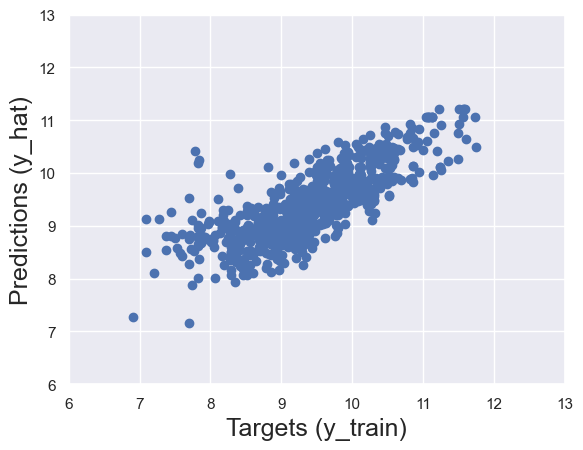

In [66]:
plt.scatter(y_test, y_hat)
plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predictions (y_hat)',size=18)
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

Text(0.5, 1.0, 'Residuals PDF')

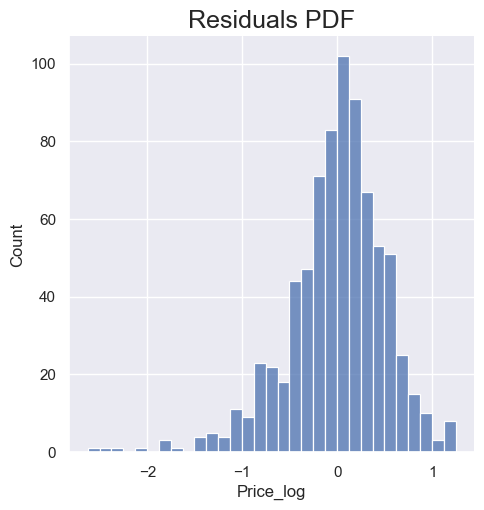

In [67]:
#Residual is the difference between the targets and the predictions
sns.displot(y_test - y_hat)
plt.title("Residuals PDF", size=18)

In [70]:
reg.score(X_test,y_test)

0.6234233960360517

### Finding the weights and bias

In [71]:
reg.intercept_

10.267674100162745

In [72]:
reg.coef_

array([ 0.14920439, -0.06513722, -0.14323645, -0.68259808, -0.29547497,
       -0.63457316,  0.07014   ,  0.64324254, -0.10641454,  0.13499392,
       -0.36874345, -0.0053432 ,  0.15492964, -0.00756945,  0.02506025])

In [73]:
reg_summary = pd.DataFrame(X.columns.values, columns=['Features'])
reg_summary['Weights'] = reg.coef_
reg_summary

,Features,Weights
0,Brand_Mercedes-Benz,0.149204
1,Brand_Audi,-0.065137
2,Brand_Toyota,-0.143236
3,Brand_Renault,-0.682598
4,Brand_Volkswagen,-0.295475
5,Brand_Mitsubishi,-0.634573
6,Body_van,0.070140
7,Body_crossover,0.643243
8,Body_vagon,-0.106415
9,Body_other,0.134994


## Testing

In [ ]:
y_hat_test = reg.predict(x_test)

In [ ]:
x_test

In [ ]:
plt.scatter(y_test, y_hat_test, alpha=0.2)
plt.xlabel('Targets (y_test)',size=18)
plt.ylabel('Predictions (y_hat_test)',size=18)
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

In [ ]:
df_pf = pd.DataFrame(np.exp(y_hat_test), columns=['Prediction'])
df_pf.head()

In [ ]:
df_pf['Target'] = np.exp(y_test)
df_pf

In [ ]:
y_test = y_test.reset_index(drop=True)
y_test.head()

In [ ]:
df_pf['Target'] = np.exp(y_test)
df_pf

In [ ]:
df_pf['Residual'] = df_pf['Target'] - df_pf['Prediction']

In [ ]:
df_pf['Difference%'] = np.absolute(df_pf['Residual']/df_pf['Target']*100)
df_pf

In [ ]:
df_pf.describe()

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_pf.sort_values(by=['Difference%'])

In [ ]:
reg.feature_names_in_

In [ ]:
reg.predict(np.array([0,2,0,0,0,0,0,0,0,0,0,1,0,0,1,0]).reshape(1, -1))